In [11]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [12]:
from tensorflow.keras.models import load_model
loaded_model_imageNet = load_model("skin_xai_model.h5")
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

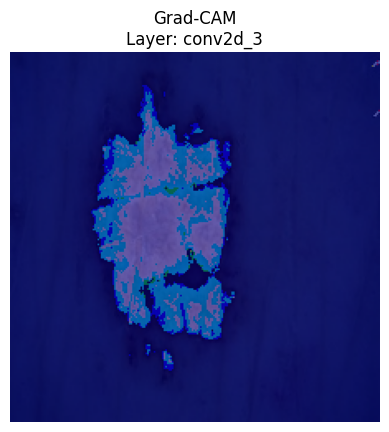

In [13]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    # for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate the gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Calculate the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


def save_and_display_gradcam(model, img_path, layer_name, cam_path="save_cam_image.jpg", alpha=0.4):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Get the Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, layer_name)
    
    # Resize heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_array[0].astype('uint8'), alpha, heatmap, 1-alpha, 0)

    # Save the superimposed image
    cv2.imwrite(cam_path, superimposed_img)

    # Display the Grad-CAM visualization
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Grad-CAM\nLayer: {layer_name}')
    plt.show()


# Define the layer name
layer_name = "conv2d_3"

# Specify the image path
img_path = '7.jpg'

# Call the function to generate Grad-CAM and display
save_and_display_gradcam(loaded_model_imageNet, img_path, layer_name)
